In [1]:
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
from functools import partial

# Should be >=0.3.20 for `jax.debug` package
print(jax.__version__)


def fori_loop(lower, upper, body_fun, init_val):
    val = init_val
    for i in range(lower, upper):
        val = body_fun(i, val)
    return val


def while_loop(cond_fun, body_fun, init_val):
    val = init_val
    while cond_fun(val):
        val = body_fun(val)
    return val

# from jax.lax import fori_loop, while_loop

0.3.20


In [2]:
A = np.array([[-1,1], [0,-1]])

def f(A, x0, t):
  return np.dot(jax.scipy.linalg.expm(A * t), x0)

# multiple neurons: 
y0 = np.array([0.0, 1.0])
neurons = np.tile(y0, (10, 1))
print(neurons.shape)

f_multi = jax.vmap(partial(f, A), (0, None))

(10, 2)


In [3]:
xs = np.arange(0,10,0.001)
ys = jax.vmap(partial(f, A, y0))(xs)

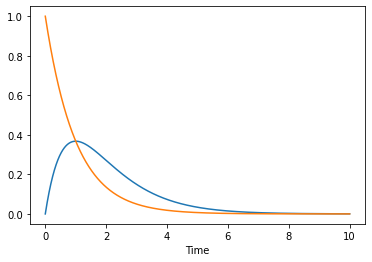

In [4]:
plt.xlabel('Time')
plt.plot(xs, ys)

In [5]:
def heaviside(x):
  return 0.5 + 0.5 * np.sign(x)

def kernel(A, t, t0):
  return heaviside(t - t0) * jax.scipy.linalg.expm(A * (t - t0))

def f(A, t0, x0, t):
  return np.einsum("ijk, ik -> j", jax.vmap(partial(kernel, A, t))(t0), x0)

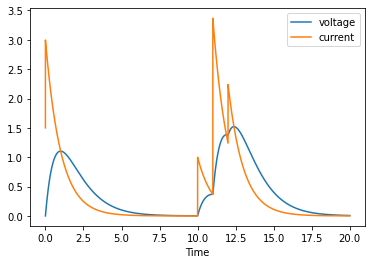

In [6]:
# neuron dynamics
A = np.array([[-1,1], [0,-1]])
# spike times
tk = np.array([0.0, 10.0, 11.0, 12.0])
# strength of "synaptic input"
xk = np.array([[0.0, 3.0], [0.0, 1.0], [0.0, 3.0], [0.0, 1.0]]) 

ts = np.arange(0,20,0.001) # time grid to evaluate on
ys = jax.vmap(partial(f, A, tk, xk))(ts)

plt.xlabel('Time')
plt.plot(ts, ys)
plt.legend(['voltage', 'current'])

In order to determine whether any jump had occured it is sufficient to focus on a given time interval $[t_k, t_{k+1}]$, we can then consider a jump condition $j$, for example one that is affine
$$j(t) = P y(t) - b$$
and do a root finding procedure on this interval.

In [7]:
# c.f.: https://github.com/google/jax/issues/8744
def newton(f, x0):
  """Newton's method for root-finding."""
  initial_state = (0, x0)

  def cond(state):
    it, x = state
    return (it < 10)

  def body(state):
    it, x = state
    fx, dfx = f(x), jax.grad(f)(x)
    step = fx / dfx
    new_state = it + 1, x - step
    return new_state

  return jax.lax.while_loop(
    cond,
    body,
    initial_state,
  )[1]


  # c.f.: https://github.com/google/jax/issues/8744
def newton_with_bound(f, x0, x1):
  """Newton's method for root-finding."""
  initial_state = (0, x0, True)

  def cond(state):
    it, x, cont = state
    return (it < 10) & cont

  def body(state):
    it, x, stop = state
    fx, dfx = f(x), jax.grad(f)(x)
    step = fx / dfx
    # print(f"Fx: {fx}, dfx: {dfx}, step: {fx / dfx}")
    x_next = x - step 
    new_state = it + 1, x_next, (x_next > x0) & (x_next < x1)
    return new_state

  return while_loop(
    cond,
    body,
    initial_state,
  )[1]

In [8]:
def bisection(f, x_min, x_max, tol):
  """Bisection root finding method

  Based on the intermediate value theorem, which
  guarantees for a continuous function that there
  is a zero in the interval [x_min, x_max] as long
  as sign(f(x_min)) != sign(f(x_max)).

  NOTE: We do not check the precondition sign(f(x_min)) != sign(f(x_max)) here
  """
  initial_state = (0, x_min, x_max)  # (iteration, x)

  def cond(state):
    it, x_min, x_max = state
    return np.abs(f(x_min)) > tol & it < 10 

  def body(state):
    it, x_min, x_max = state
    x = (x_min + x_max)/2

    sfxm = np.sign(f(x_min))
    sfx = np.sign(f(x)) 

    x_min = np.where(sfx == sfxm, x, x_min)
    x_max = np.where(sfx == sfxm, x_max, x)

    new_state = (it + 1, x_min, x_max)
    return new_state

  return while_loop(
    cond,
    body,
    initial_state,
  )[1]

In [14]:
def first_root(solver, x0, dt):
  """Bisection root finding method

  Previously check that at least one transition occureed.
  """
  initial_state = (0, x0, 0, dt)  # (iteration, x)

  def cond(state):
    # check that at least one condition occured
    it = state[0]
    return it < 5

  def body(state):
    it, x, t, dt = state
    dt = dt / 2
    x_new = solver(x, dt)

    # TODO take jump condition as function argument
    cond = np.any(x_new[:,0] > 0.3)
    t = t + dt * (not cond)
    x = x * cond + x_new * (not cond)
    return (it + 1, x, t, dt)

  return while_loop(
    cond,
    body,
    initial_state,
  )

def tr_equation(x, tr, spike_idx):
  x = x.at[spike_idx, 0].set(0.0)
  i_new = x[:, 1] + tr[spike_idx]
  return np.stack((x[:, 0], i_new), axis=1)

def integrate_to_next_jump_or_dt(solver, x, tr, t, dt):
  x_int = solver(x, dt)
  if not np.any(x_int[:,0] > 0.3):
    t += dt
    return x_int, t, False

  if first_root(solver, x, dt)[2] == 0.0:
    print("How can this happen?!")
    # we need to make sure that we always integrate at least to 1 / dt^5, otherwise we'll get hung up if there are too many spikes
    a = 3

  _, x_int, t_spike, _ = first_root(solver, x, dt)
  spike_idx = np.argmax(x_int[:, 0])
  n_spikes = len(x_int[np.where(x_int[:, 0] > 0.3)])
  print(f"{n_spikes} spikes after {t:.5f} seconds")

  x_tr = tr_equation(x_int, tr, spike_idx)
  if t_spike == 0.0:
    assert False
  return x_tr, t + t_spike, True

def integrate_until(solver, x, tr, t, dt, t_until):
  while t < t_until:
    dt = np.minimum(dt, t_until-t)
    x, t, spike = integrate_to_next_jump_or_dt(solver, x, tr, t, dt)
  return x, t


In [15]:
A = np.array([[-1,1], [0,-1]])
n_neurons = 100

def f(A, x, t):
  return np.dot(jax.scipy.linalg.expm(A * t), x)

def solver(x, dt):
  A = np.array([[-1,1], [0,-1]])
  return np.dot(jax.scipy.linalg.expm(A * dt), x)

def init_state(rng, n_neurons):
  v = np.zeros(n_neurons)
  i = jax.random.normal(rng, (n_neurons,))
  return np.stack((v, i), axis=1)

batched_solver = jax.vmap(solver, in_axes=(0, None))

rng = jax.random.PRNGKey(42)
rng, tr_key = jax.random.split(rng)
x = init_state(rng, n_neurons)
tr = jax.random.normal(tr_key, (n_neurons, n_neurons))

# iterate input spikes
t = 0.0
dt = 1.0
input_spikes = np.array([1.0, 2.0, 3.0, 20.0])
for spike_time in input_spikes:
  spike_idx = 0
  x = tr_equation(x, tr, spike_idx)
  x, t = integrate_until(batched_solver, x, tr, t, dt, spike_time)


0 spikes after 0.00000 seconds
0 spikes after 0.06250 seconds
0 spikes after 0.09180 seconds
0 spikes after 0.12018 seconds
How can this happen?!
0 spikes after 0.14767 seconds


AssertionError: 

In [ ]:
# we can not use scan for spike times as output would be spares or 0
key = jax.random.PRNGKey(42)
def foo(key, b):
    key, subkey = jax.random.split(key)
    res = jax.random.normal(subkey, (1, ))
    return jax.lax.cond(np.all(res > 0.5), lambda: None, lambda: 1.0)

res = jax.lax.scan(foo, key, np.zeros(10))

In [125]:

y0 = np.array([0.0, 1.0])


xs = np.arange(0,10,0.01)
ys = jax.vmap(partial(jc, y0))(xs)

0.48940238


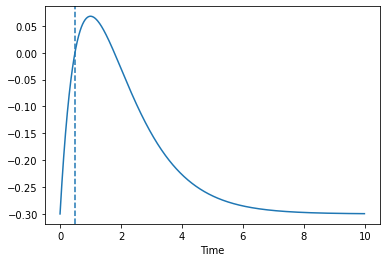

In [78]:
spike_time = newton(partial(jc, y0), 0.5)
# spike_time_ = bisection(jc, 0.0, 10.0, 0.001)
print(spike_time)
plt.xlabel('Time')
plt.plot(xs, ys)
plt.axvline(spike_time, linestyle='--')
# plt.axvline(spike_time_, linestyle='-.')

In [79]:
A = np.array([[-1,1], [0,-1],
    # [[-0.8,0.8], [0,-.8]],
    # [[-.7,.7], [0,-.7]],
    # [[-.5,.5], [0,-.5]]
])

# y0 = np.array([[0.0, 1.0],[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]])
y0 = np.array([[0.0, 1.0]])


def f(A, x0, t):
  return np.dot(jax.scipy.linalg.expm(A * t), x0)

def jump_condition(f, v_th, y0, t):
  return f(y0, t)[0] - v_th # this implements the P y(t) - b above

jc = partial(jump_condition, partial(f, A[0]), 0.3)


In [85]:
def f(A, x0, t):
  return np.dot(jax.scipy.linalg.expm(A * t), x0)

def jump_condition(f, v_th, y0, t):
  return f(y0, t)[0] - v_th # this implements the P y(t) - b above

def transition_equation(y):
  return np.array([0.0, y[1]])

def integrate_to_next_jump( 
    dynamics, 
    jump_condition,
    transition_equation,
    y_0
):
  jc = partial(jump_condition, dynamics, 0.3, y_0)
  spike_time = newton_with_bound(jc, 0.0, 10.0)
  y_minus = partial(dynamics, y_0)(spike_time)
  y_plus = transition_equation(y_minus)

  return (spike_time, y_minus, y_plus)


In [86]:
# now for multiple neurons
def propagate_spike(states, connection, spike_idx):
    states.at[:, 1].set(states[:, 1] * connection[spike_idx])
    states.at[spike_idx, 0].set(0.0)
    return states

n_neurons = 10
int = partial(integrate_to_next_jump, partial(f, A), jump_condition, transition_equation)
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)

connection = jax.random.normal(subkey, (n_neurons, n_neurons))
states = jax.random.normal(key, (n_neurons, 2))
batched_int = jax.vmap(int)
import time

for i in range(10):
    start = time.time()
    states = batched_int(states)
    print(f"Integration: {time.time()-start:.2f}")
    t_spikes = states[0]

    # TODO what if no neuron spikes? Take next external event instead of spike time
    spike_idx = np.argmin(t_spikes[np.where(t_spikes >= 0)])
    spike_time = states[0][spike_idx]

    # integrate all neurons to spike_time
    states = jax.vmap(partial(f, A), in_axes=(0, None))(neurons, spike_time)
    states = propagate_spike(states, connection, spike_idx)
    print(states.shape)


# add 


Integration: 2.40
(10, 2)
Integration: 2.46
(10, 2)
Integration: 2.35
(10, 2)
Integration: 2.33


ValueError: attempt to get argmin of an empty sequence

In [ ]:
import time
jitted = jax.jit(partial(integrate_to_next_jump, partial(f, A), jump_condition, transition_equation))
jitted(np.array([0.0, 1.0]))
start = time.time()
[jitted(np.array([0.0, 1.0])) for i in range(10_000)]
print(time.time() - start)
# integrate_to_next_jump(partial(f, A), jump_condition, transition_equation, np.array([0.0, 1.0]))

2.0359280109405518


0.48940223


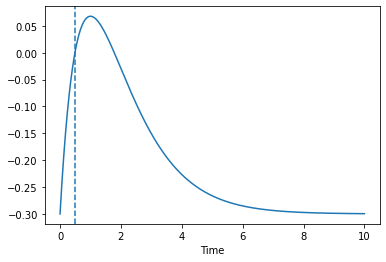

In [182]:
jc = partial(jump_condition, partial(f, A), 0.3, np.array([0.0, 1.0]))
xs = np.arange(0,10,0.001)
ys = jax.vmap(jc)(xs)

spike_time = newton_with_bound(jc, 0.0, 10.0)

print(spike_time)
plt.xlabel('Time')
plt.plot(xs, ys)
plt.axvline(spike_time, linestyle='--')

In [183]:
A = np.array([[-1.0,1.0], [0.0,-1.0]])

def f(A, x0, t):
  return np.dot(jax.scipy.linalg.expm(A * t), x0)

def jump_condition(f, v_th, y0, t):
  return f(y0, t)[0] - v_th # this implements the P y(t) - b above

def transition_equation(y):
  return np.array([0.0, y[1]])

y0 = np.array([0.0, 1.0])
ft = partial(f, A)
jc = partial(jump_condition, ft, 0.3)

In [217]:
def forward_integration(
      dynamics, 
      jump_condition,
      transition_equation,
      initial_state,       
      t_max, 
    ):
  """
  """

  def cond(state):
    it, t, y, acc = state
    return t < t_max

  def body(state):
    it, t, y, acc = state  # t is current lower bound
    # 1. find next transition
    jc = partial(jump_condition, y)

    # calculate always from 
    t_next = newton_with_bound(jc, 0.0, t_max - t) + t

    # only integrate to boundary ...
    t_dyn = np.where(np.logical_or(t_next > t_max, t_next <= t), t_max, t_next)

    # 2. compute y_minus
    y_minus = partial(dynamics, y)(t_dyn)

    # 3. compute transition (in so far we did not reach the boundary)
    y_plus = np.where(t_next > t_max, y_minus, transition_equation(y_minus))

    acc = acc.at[it, 0].set(t_dyn)
    acc = acc.at[it, 1:].set(y_plus)

    new_state = (it+1, t_dyn, y_plus, acc)
    return new_state

  return while_loop(
    cond,
    body,
    initial_state,
  )

In [221]:
fi = partial(forward_integration, ft, jc, transition_equation)
initial_state = (0, 0.0, y0, np.zeros((100, 3)))
new_state = fi(initial_state, 100.0)

In [224]:
def forward(fi, stop, spikes):

    def body_fun(i, state):
        it, t, y_old, acc = state
        y_new = np.array([y_old[0], y_old[1] + 1])
        return fi((it, t, y_new, acc), tk[i+1])

    acc = np.zeros((100,3))
    y0 = np.array([0.0, 0.0])
    t = spikes[0]
    acc.at
    it = 1
    acc = 
    state = it, t, y0, acc
    spikes = np.append(spikes, stop)
    return fori_loop(0, len(spikes) - 1, body_fun, state)

In [252]:
# spike times
tk = np.array([0.0, 10.0, 11.1, 11.2, 11.25, 12.0, 31.0])
it, t, y, acc = forward(fi, 100, tk)
spikes = acc[np.logical_and(acc[:, 1] == 0.0, acc[:, 0] != 0.0)]

In [260]:
def trace_from_acc(dynamics, acc, times, y0):
    y = y0
    i = 0
    states = np.zeros((len(times), 2))
    for spike in spikes:
        t_prev = times[times < spike]
        f = partial(dynamics, y)
        states = states.at[i: i + len(t_prev)].set(jax.vmap(f)(t_prev))
        y = f(spike) + np.array([0.0, 1.0])
        i += t_prev
    return states

In [261]:
times = np.arange(0, 15, 0.01)
trace_from_acc(ft, acc, times, y0)

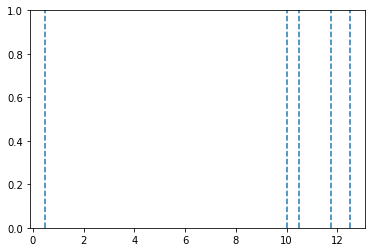

In [256]:
for spike_time in spikes[:,0]:
    plt.axvline(spike_time, linestyle='--')

plt.show()